## AFNI Deoblique

This notebook explores the implementation of *deobliquing* operations in AFNI, in order to be able to correctly manipulate transforms generated by the tool, and to produce transforms that can be correctly applied with AFNI.
Most of the preparation comes from the previous notebook.

This notebook is the test bed for resolving [issue #45](https://github.com/poldracklab/nitransforms/issues/45)

### Preamble
Prepare a Python environment and use a temporal directory for the outputs. After that, fetch the actual file from NiBabel documentation.

In [76]:
%load_ext autoreload
%matplotlib inline

import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import nibabel as nb
import nitransforms as nt
from nipype.interfaces.afni import Warp

cwd = TemporaryDirectory()
os.chdir(cwd.name)
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/tmp/tmppk0m5zaq


In [77]:
!wget https://nipy.org/nibabel/_downloads/62985f4c43f499609fa65cb2eb955b79/someones_anatomy.nii.gz

--2019-11-13 09:34:55--  https://nipy.org/nibabel/_downloads/62985f4c43f499609fa65cb2eb955b79/someones_anatomy.nii.gz
Resolving nipy.org (nipy.org)... 185.199.108.153, 185.199.110.153, 185.199.111.153, ...
Connecting to nipy.org (nipy.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191449 (187K) [application/gzip]
Saving to: ‘someones_anatomy.nii.gz’

someones_anatomy.ni 100%[===================>] 186.96K  --.-KB/s    in 0.007s  

2019-11-13 09:34:55 (25.2 MB/s) - ‘someones_anatomy.nii.gz’ saved [191449/191449]



### Load in the image
Let's first visualize the example image, and retain some copies of the original header and affine.

<OrthoSlicer3D: someones_anatomy.nii.gz (57, 67, 56)>

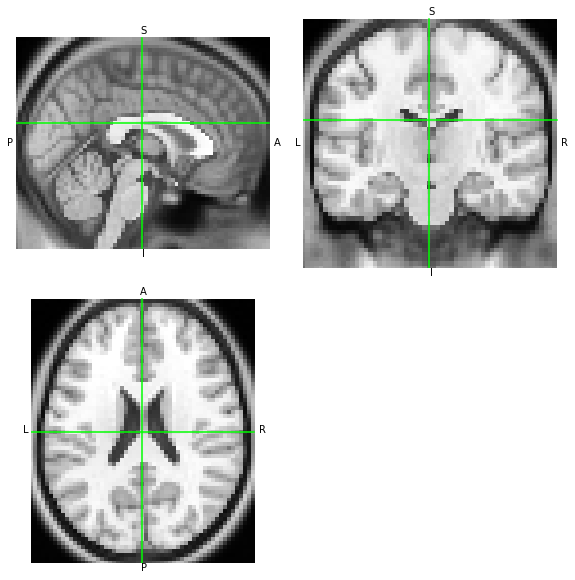

In [78]:
# Load the example
nii = nb.load('someones_anatomy.nii.gz')
hdr = nii.header.copy()
aff = nii.affine.copy()
data = np.asanyarray(nii.dataobj)
nii.orthoview()

### Generating variants
Playing with the affine header and the data array ordering of axes and elements we generate several versions of the dataset with different orientations (LAS, LPS, oblique, LPS oblique).

In [79]:
# Create LAS version
las_aff = aff.copy()
las_aff[0, 0] *= -1.0
las_aff[0, 3] = aff.dot(np.hstack((np.array(nii.shape[:3]) - 1, 1.0)))[0]

las = nb.Nifti1Image(np.flip(data, 0), las_aff, nii.header)
las.to_filename('someones_anatomy_LAS.nii.gz')

# Create LPS version
lps_aff = aff.copy()
lps_aff[0, 0] *= -1.0
lps_aff[1, 1] *= -1.0
lps_aff[:2, 3] = aff.dot(np.hstack((np.array(nii.shape[:3]) - 1, 1.0)))[:2]

lps = nb.Nifti1Image(np.flip(np.flip(data, 0), 1), lps_aff, nii.header)
lps.to_filename('someones_anatomy_LPS.nii.gz')

# Create version not aligned to canonical
R = nb.affines.from_matvec(nb.eulerangles.euler2mat(x=0.09, y=0.001, z=0.001))
M = R.dot(nii.affine)
new = nb.Nifti1Image(data, M, hdr)
new.header.set_qform(M, 1)
new.header.set_sform(M, 1)
new.to_filename('someones_anatomy_rot.nii.gz')

# Create version not aligned to canonical (LPS)
lpsM = R.dot(lps.affine)
lpsnew = nb.Nifti1Image(np.flip(np.flip(data, 0), 1), lpsM, hdr)
lpsnew.header.set_qform(lpsM, 1)
lpsnew.header.set_sform(lpsM, 1)
lpsnew.to_filename('someones_anatomy_lpsrot.nii.gz')

### Print affines of interest
Output some affines that we will want to compare to their counterparts generated by AFNI and stored in the NIfTI header

In [194]:
print(new.affine)
print(R.dot(nii.affine))
R[:3, :3].dot(nii.affine[:3, 3])

[[ 2.74999725e+00 -2.74999817e-03  2.74999954e-03 -7.79999220e+01]
 [ 2.98603540e-03  2.73886840e+00 -2.47165887e-01 -8.25373961e+01]
 [-2.49170222e-03  2.47168626e-01  2.73886865e+00 -9.87400142e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 2.74999725e+00 -2.74999817e-03  2.74999954e-03 -7.79999220e+01]
 [ 2.98603540e-03  2.73886840e+00 -2.47165887e-01 -8.25373961e+01]
 [-2.49170222e-03  2.47168626e-01  2.73886865e+00 -9.87400142e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


array([-77.99992205, -82.53739614, -98.74001417])

In [80]:
print(np.linalg.inv(np.diag([-1, -1, 1, 1]).dot(R)).T)

[[-9.99999000e-01  9.99999333e-04 -9.99999833e-04  0.00000000e+00]
 [-1.08583106e-03 -9.95952145e-01  8.98785043e-02  0.00000000e+00]
 [-9.06073535e-04  8.98795002e-02  9.95952235e-01  0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Run `3dWarp -deoblique`
Generate one example image after "deobliquing", to then see if we can generate equivalent composite transforms

In [81]:
#!3dWarp -deoblique -prefix deoblps.nii.gz someones_anatomy_lpsrot.nii.gz
Warp(in_file='someones_anatomy_rot.nii.gz', deoblique=True, verbose=True, out_file='deob.nii.gz').run()

191113-09:35:00,729 nipype.interface INFO:
	 stderr 2019-11-13T09:35:00.729908:++ 3dWarp: AFNI version=AFNI_16.0.01 (Jan 27 2016) [64-bit]
191113-09:35:00,731 nipype.interface INFO:
	 stderr 2019-11-13T09:35:00.729908:++ Authored by: RW Cox
191113-09:35:00,732 nipype.interface INFO:
	 stderr 2019-11-13T09:35:00.732404:** AFNI converts NIFTI_datatype=2 (UINT8) in file someones_anatomy_rot.nii.gz to FLOAT32
191113-09:35:00,733 nipype.interface INFO:
	 stderr 2019-11-13T09:35:00.732404:     Warnings of this type will be muted for this session.
191113-09:35:00,733 nipype.interface INFO:
	 stderr 2019-11-13T09:35:00.732404:     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
191113-09:35:00,734 nipype.interface INFO:
	 stderr 2019-11-13T09:35:00.732404:++ Using minimum spacing of 2.750000 mm for new grid spacing
191113-09:35:00,785 nipype.interface INFO:
	 stderr 2019-11-13T09:35:00.785593:++ Output dataset ./deob.nii.gz
191113-09:35:00,786 nipype.interface INFO:
	 stdout 2

### Generating AFNI's "deobliquing" matrices

Based on the image's information, we need to reconstruct AFNI's `WARPDRIVE_MATVEC_FOR_000000` affine, and then check that the results of applying such a matrix ends in the same outcome with AFNI and NiTransforms tools.

In [204]:
from nibabel.affines import from_matvec
B = np.ones((2, 2))
AFNI_SIGNS = np.block([[B, -1.0 * B], [-1.0 * B, B]])
def _afni_warpdrive_for(oblique, plumb, offset=True, inv=False):
    """
    Calculate AFNI's ``WARPDRIVE_MATVEC_FOR_000000`` (de)obliquing affine.

    Parameters
    ----------
    oblique : 4x4 numpy.array
        affine that is not aligned to the cardinal axes.
    plumb : 4x4 numpy.array
        corresponding affine that is aligned to the cardinal axes.


    Returns
    -------
    plumb_to_oblique : 4x4 numpy.array
        the matrix that pre-pended to the plumb affine rotates it
        to be oblique.

    """
    R = np.linalg.inv(plumb[:3, :3]).dot(oblique[:3, :3])
    origin = oblique[:3, 3] - R.dot(oblique[:3, 3])
    if offset is False:
        origin = np.zeros(3)
    matvec_inv = from_matvec(R, origin) * AFNI_SIGNS
    if not inv:
        return np.linalg.inv(matvec_inv)
    return matvec_inv

### Inspecting affines and headers
Generate a rotation affine to apply on the original affine of an image, and try to reconstruct the inverse of it as AFNI calculates it.

The following cells are just prior information useful for when we arrive to the next section

In [209]:
R = nb.affines.from_matvec(nb.eulerangles.euler2mat(x=0.09, y=0.001, z=0.001))
# D = _afni_to_oblique(new.affine, nii.affine)
# print(R)
# print(D)
print(_afni_warpdrive_for(new.affine, nii.affine, offset=False))

[[ 9.99999000e-01  1.08583106e-03  9.06073535e-04  0.00000000e+00]
 [-9.99999333e-04  9.95952145e-01 -8.98795002e-02  0.00000000e+00]
 [-9.99999833e-04  8.98785043e-02  9.95952235e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [110]:
print(deob.header.extensions[0].get_content().decode())

<?xml version='1.0' ?>
<AFNI_attributes
  self_idcode="XYZ_5BVhie9GEKQyZ5eTUAHGAw"
  NIfTI_nums="58,72,62,1,1,16"
  ni_form="ni_group" >
<AFNI_atr
  ni_type="String"
  ni_dimen="1"
  atr_name="HISTORY_NOTE" >
 "[oesteban@dendrite: Tue Nov 12 08:53:31 2019] 3dWarp -deoblique -prefix deob.nii.gz -verb someones_anatomy_rot.nii.gz"
</AFNI_atr>

<AFNI_atr
  ni_type="float"
  ni_dimen="12"
  atr_name="WARPDRIVE_MATVEC_FOR_000000" >
 0.999999
 0.001085831
 0.0009060735
 -7.40746e-05
 -0.0009999992
 0.9959521
 -0.0898795
 -8.462602
 -0.0009999998
 0.0898785
 0.9959521
 -7.740018
</AFNI_atr>

<AFNI_atr
  ni_type="float"
  ni_dimen="12"
  atr_name="WARPDRIVE_MATVEC_INV_000000" >
 0.999999
 -0.0009999993
 -0.0009999998
 -0.01612854
 0.001085831
 0.9959522
 0.08987851
 9.124008
 0.0009060736
 -0.08987951
 0.9959523
 6.948074
</AFNI_atr>

<AFNI_atr
  ni_type="String"
  ni_dimen="1"
  atr_name="TYPESTRING" >
 "3DIM_HEAD_ANAT"
</AFNI_atr>

<AFNI_atr
  ni_type="String"
  ni_dimen="1"
  atr_name="IDCOD

In [50]:
print(R.T)
print(R.dot(nii.affine[:, 3]) - nii.affine[:, 3])
print(nii.affine[:, 3] - new.affine[:, 3])
print(new.affine[:, 3] - np.linalg.inv(R).T.dot(new.affine[:, 3]))

[[ 9.99999000e-01  1.08583106e-03 -9.06073535e-04  0.00000000e+00]
 [-9.99999333e-04  9.95952145e-01  8.98795002e-02  0.00000000e+00]
 [ 9.99999833e-04 -8.98785043e-02  9.95952235e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 7.79544740e-05  8.46260386e+00 -7.74001417e+00  0.00000000e+00]
[-7.79544740e-05 -8.46260386e+00  7.74001417e+00  0.00000000e+00]
[ 0.01612466 -9.12400945  6.94806988  0.        ]


In [75]:
print('\n'.join([str(row) for row in _afni_deoblique(new.affine, nii.affine)]))

[ 0.999999   -0.001       0.001       0.01612466]
[ 1.08583106e-03  9.95952145e-01 -8.98785043e-02 -9.12400945e+00]
[-9.06073535e-04  8.98795002e-02  9.95952235e-01  6.94806988e+00]
[0. 0. 0. 1.]


In [42]:
print(new.affine[:, 3] - nii.affine[:, 3])

print(nb.as_closest_canonical(new).affine)
print(new.affine)
print(new.header.get_best_affine())

[ 7.79544740e-05  8.46260386e+00 -7.74001417e+00  0.00000000e+00]
[[ 2.74999725e+00 -2.74999817e-03  2.74999954e-03 -7.79999220e+01]
 [ 2.98603540e-03  2.73886840e+00 -2.47165887e-01 -8.25373961e+01]
 [-2.49170222e-03  2.47168626e-01  2.73886865e+00 -9.87400142e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 2.74999725e+00 -2.74999817e-03  2.74999954e-03 -7.79999220e+01]
 [ 2.98603540e-03  2.73886840e+00 -2.47165887e-01 -8.25373961e+01]
 [-2.49170222e-03  2.47168626e-01  2.73886865e+00 -9.87400142e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 2.74999714e+00 -2.74999812e-03  2.74999952e-03 -7.79999237e+01]
 [ 2.98603531e-03  2.73886847e+00 -2.47165889e-01 -8.25373993e+01]
 [-2.49170233e-03  2.47168630e-01  2.73886871e+00 -9.87400131e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [23]:
afni_dicom = np.diag([-1, -1, 1, 1]).dot(new.affine)
print(afni_dicom)

[[-2.74999725e+00  2.74999817e-03 -2.74999954e-03  7.79999220e+01]
 [-2.98603540e-03 -2.73886840e+00  2.47165887e-01  8.25373961e+01]
 [-2.49170222e-03  2.47168626e-01  2.73886865e+00 -9.87400142e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [14]:
deob = nb.load('deob.nii.gz')

print(nii.affine)
print(new.affine)
print(deob.affine)

[[  2.75   0.     0.   -78.  ]
 [  0.     2.75   0.   -91.  ]
 [  0.     0.     2.75 -91.  ]
 [  0.     0.     0.     1.  ]]
[[ 2.74999725e+00 -2.74999817e-03  2.74999954e-03 -7.79999220e+01]
 [ 2.98603540e-03  2.73886840e+00 -2.47165887e-01 -8.25373961e+01]
 [-2.49170222e-03  2.47168626e-01  2.73886865e+00 -9.87400142e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ -2.75        -0.          -0.          77.35987854]
 [ -0.          -2.75        -0.          98.75680542]
 [  0.           0.           2.75       -99.2093277 ]
 [  0.           0.           0.           1.        ]]


In [15]:
print(new.affine[:, -1])
print(R.dot(deob.affine[:, -1]))

[-77.99992205 -82.53739614 -98.74001417   1.        ]
[ 77.16183513 107.35783795 -90.00163308   1.        ]


In [8]:
center = lps.affine[:3, :3].dot(np.array(lps.shape) - 0.5) * -0.5
origin = lps.affine[:3, -1]

print(center)
print(center - origin)

[ 77.6875  91.4375 -76.3125]
[ 1.6875  0.9375 14.6875]


In [9]:
center = lpsnew.affine[:3, :3].dot(np.array(lpsnew.shape) - 0.5) * -0.5
origin = lpsnew.affine[:3, -1]
print(center - origin)

[ 1.70124831 -0.38455306 14.71078148]


In [10]:
R_afni = deob.affine.dot(np.linalg.inv(lpsnew.affine))
print(R_afni)
print(np.linalg.inv(R))

[[ 9.99999000e-01  1.08583106e-03 -9.06073535e-04  1.35987854e+00]
 [-9.99999333e-04  9.95952145e-01  8.98795002e-02  8.25680542e+00]
 [ 9.99999833e-04 -8.98785043e-02  9.95952235e-01 -8.20932770e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99999000e-01  1.08583106e-03 -9.06073535e-04  0.00000000e+00]
 [-9.99999333e-04  9.95952145e-01  8.98795002e-02  0.00000000e+00]
 [ 9.99999833e-04 -8.98785043e-02  9.95952235e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [11]:
print(deob.header.extensions[0].get_content().decode())

<?xml version='1.0' ?>
<AFNI_attributes
  self_idcode="XYZ_OAi4s_U-_iTkOb4zdPzWjg"
  NIfTI_nums="58,72,62,1,1,16"
  ni_form="ni_group" >
<AFNI_atr
  ni_type="String"
  ni_dimen="1"
  atr_name="HISTORY_NOTE" >
 "[oesteban@dendrite: Tue Nov 12 08:52:11 2019] 3dWarp -deoblique -prefix deoblps.nii.gz -verb someones_anatomy_lpsrot.nii.gz"
</AFNI_atr>

<AFNI_atr
  ni_type="float"
  ni_dimen="12"
  atr_name="WARPDRIVE_MATVEC_FOR_000000" >
 0.999999
 0.001085831
 0.0009060735
 0.1815765
 -0.0009999992
 0.9959521
 -0.0898795
 -7.895141
 -0.0009999998
 0.0898785
 0.9959521
 8.433576
</AFNI_atr>

<AFNI_atr
  ni_type="float"
  ni_dimen="12"
  atr_name="WARPDRIVE_MATVEC_INV_000000" >
 0.999999
 -0.0009999993
 -0.0009999998
 -0.1810379
 0.001085831
 0.9959522
 0.08987851
 7.104988
 0.0009060736
 -0.08987951
 0.9959523
 -9.109215
</AFNI_atr>

<AFNI_atr
  ni_type="String"
  ni_dimen="1"
  atr_name="TYPESTRING" >
 "3DIM_HEAD_ANAT"
</AFNI_atr>

<AFNI_atr
  ni_type="String"
  ni_dimen="1"
  atr_name="IDC

### Reverse-engineering matrix compositions of oblique datasets
Calculating AFNI's affines based on the oblique image information

In [38]:
R_afni = nb.load('deob.nii.gz').affine.dot(np.linalg.inv(new.affine))
print(R_afni)
print(np.linalg.inv(R))

[[-9.99999000e-01 -1.08583106e-03  9.06073535e-04 -6.40121460e-01]
 [ 9.99999333e-04 -9.95952145e-01 -8.98795002e-02  7.75680542e+00]
 [ 9.99999833e-04 -8.98785043e-02  9.95952235e-01 -8.20932770e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99999000e-01  1.08583106e-03 -9.06073535e-04  0.00000000e+00]
 [-9.99999333e-04  9.95952145e-01  8.98795002e-02  0.00000000e+00]
 [ 9.99999833e-04 -8.98785043e-02  9.95952235e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [40]:
R_afni = new.affine.dot(np.linalg.inv(nb.load('deob.nii.gz').affine))
print(R_afni)
print(R)

[[-9.99999000e-01  9.99999333e-04  9.99999833e-04 -6.39668294e-01]
 [-1.08583106e-03 -9.95952145e-01 -8.98785043e-02  6.98686984e+00]
 [ 9.06073535e-04 -8.98795002e-02  9.95952235e-01  8.87385606e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99999000e-01 -9.99999333e-04  9.99999833e-04  0.00000000e+00]
 [ 1.08583106e-03  9.95952145e-01 -8.98785043e-02  0.00000000e+00]
 [-9.06073535e-04  8.98795002e-02  9.95952235e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Visually test whether we correctly apply dual transforms with both tools
Load images generated with AFNI and with NiTransforms to check whether NiTransforms is operating as expected

<OrthoSlicer3D: deob-for2.nii.gz (58, 72, 62)>

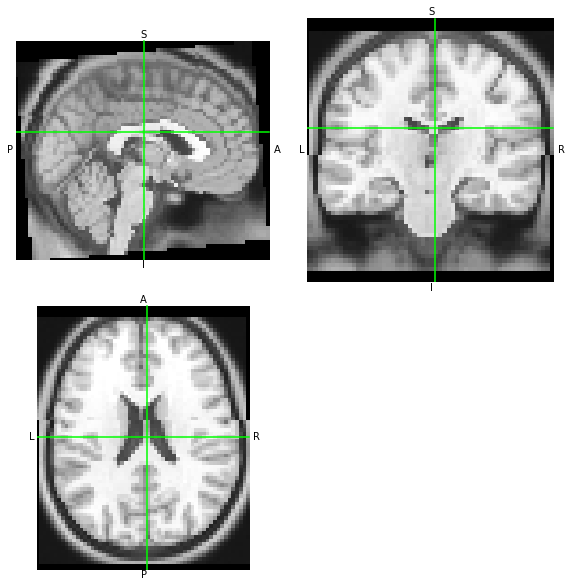

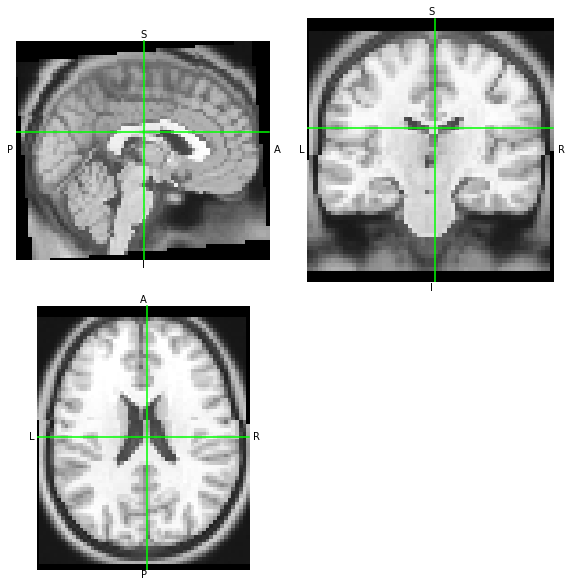

In [195]:
#!3dWarp -deoblique -prefix deob.nii.gz -NN someones_anatomy_rot.nii.gz
#!3dAllineate -base someones_anatomy.nii.gz -input someones_anatomy.nii.gz -master deob.nii.gz -1Dmatrix_apply for2.afni -prefix deob-for2.nii.gz -final NN
nb.load('deob.nii.gz').orthoview()
# nb.load('moved-for-T-inv.nii.gz').orthoview()
# nb.load('moved-inv-T-for.nii.gz').orthoview()
# nb.load('deob-for.nii.gz').orthoview()
nb.load('deob-for2.nii.gz').orthoview()
# nb.load('moved-affine-oblique-inv-T-for.nii.gz').orthoview()
# nb.load('moved-affine-oblique-inv-T-for-master.nii.gz').orthoview()

If both derivatives are resampled in the same space, the following figure should be almost (or fully) blank.

<OrthoSlicer3D: (58, 72, 62)>

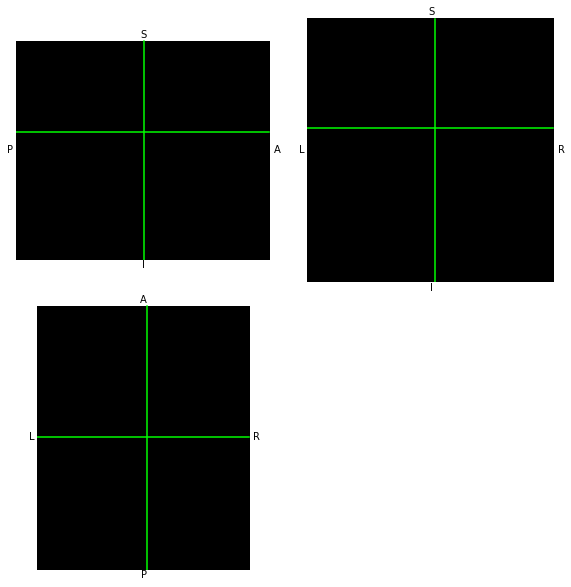

In [196]:
deob = nb.load('deob.nii.gz')
nb.Nifti1Image(np.abs(deob.get_fdata() - nb.load('deob-for2.nii.gz').get_fdata()), deob.affine, deob.header).orthoview()